<a href="https://colab.research.google.com/github/1heodora-e/biometric-recommendation-system/blob/main/Task1_DataMerge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:

# STEP 1: LOAD DATA

import pandas as pd

social_df = pd.read_csv('customer_social_profiles.csv')
trans_df = pd.read_csv('customer_transactions.csv')

print("Data loaded successfully!")
print("Head of social_df:")
display(social_df.head())
print("Head of trans_df:")
display(trans_df.head())

Data loaded successfully!
Head of social_df:


,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral


Head of trans_df:


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [69]:
print(trans_df.isnull().sum())

print("Product category distribution:\n", trans_df['product_category'].value_counts(normalize=True))

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64
Product category distribution:
 product_category
Sports         0.233333
Electronics    0.226667
Clothing       0.186667
Groceries      0.186667
Books          0.166667
Name: proportion, dtype: float64


In [70]:
from sklearn.impute import SimpleImputer


# Handle missing values
# Numerical columns: Impute with mean (purchase_amount, customer_rating)
num_cols = ['purchase_amount', 'customer_rating']

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
trans_df[num_cols] = num_imputer.fit_transform(trans_df[num_cols])

# Categorical columns: Impute with mode (product_category)
cat_cols = ['product_category']
cat_imputer = SimpleImputer(strategy='most_frequent')
trans_df[cat_cols] = cat_imputer.fit_transform(trans_df[cat_cols])

print("Skewness of customer_rating:", trans_df['customer_rating'].skew())

Skewness of customer_rating: -0.07889385715833348


In [71]:
# Data Augmentation Strategies

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


original_data = trans_df.copy()

# Adding random noise (±5%) to purchase_amount to simulate natural variations in transaction values
trans_df['purchase_amount'] = trans_df['purchase_amount'] * (1 + np.random.normal(0, 0.05, trans_df.shape[0]))  # ±5% noise

# Check skewness to decide on log transformation
print("Skewness of purchase_amount before log transformation:", trans_df['purchase_amount'].skew())

# Balancing the dataset using SMOTE based on product_category
print("Product category distribution before SMOTE:\n", trans_df['product_category'].value_counts())
le = LabelEncoder()
trans_df['product_category_encoded'] = le.fit_transform(trans_df['product_category'])
X = trans_df[['purchase_amount', 'product_category_encoded']]
y = le.transform(trans_df['product_category'])  # Encode y as integers

# Adding an index to track the original rows for mapping customer_id_legacy
trans_df['original_index'] = trans_df.index

# Applying SMOTE with adjusted k_neighbors (default is 5, which works since all classes have at least 25 samples)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
resampled_data = pd.DataFrame(X_resampled, columns=['purchase_amount', 'product_category_encoded'])
resampled_data['product_category'] = le.inverse_transform(y_resampled)

# Reconstruct the other columns for the resampled data
resampled_full_data = pd.DataFrame()
resampled_full_data['purchase_amount'] = resampled_data['purchase_amount']
resampled_full_data['product_category'] = resampled_data['product_category']

# Map customer_id_legacy to SMOTE-generated rows
# SMOTE generates new rows based on nearest neighbors; we'll approximate by sampling customer_id_legacy from the original rows
# For simplicity, I will repeat the original customer_id_legacy values to match the new length
resampled_full_data['customer_id_legacy'] = np.repeat(trans_df['customer_id_legacy'].values, len(resampled_full_data) // len(trans_df) + 1)[:len(resampled_full_data)]
resampled_full_data['transaction_id'] = 'SMOTE_' + pd.Series(range(10001, 10001 + len(resampled_full_data))).astype(str)
resampled_full_data['purchase_date'] = pd.to_datetime('2024-06-01') + pd.to_timedelta(np.random.randint(0, 30, len(resampled_full_data)), unit='D')

# Copy customer_rating from the original data, then adjust with noise
resampled_full_data['customer_rating'] = np.repeat(trans_df['customer_rating'].values, len(resampled_full_data) // len(trans_df) + 1)[:len(resampled_full_data)]
resampled_full_data['customer_rating'] += np.random.normal(0, 0.5, len(resampled_full_data))  # ±0.5 variation
resampled_full_data['customer_rating'] = np.clip(resampled_full_data['customer_rating'], 1, 5)  # Ensure ratings stay between 1 and 5

# Expanding data by generating synthetic transactions
synthetic_data = resampled_full_data.copy()

# Add slight variations to purchase_amount and customer_rating
synthetic_data['purchase_amount'] *= np.random.uniform(0.9, 1.1, synthetic_data.shape[0])  # ±10% variation
synthetic_data['customer_rating'] += np.random.normal(0, 0.5, synthetic_data.shape[0])  # ±0.5 variation
synthetic_data['customer_rating'] = np.clip(synthetic_data['customer_rating'], 1, 5)  # Ensuring ratings stay between 1 and 5

# Vary product_category by sampling from its distribution
unique_categories = trans_df['product_category'].unique()
category_probs = trans_df['product_category'].value_counts(normalize=True).reindex(unique_categories).values
synthetic_data['product_category'] = np.random.choice(
    unique_categories, size=synthetic_data.shape[0], p=category_probs
)

# Preserve customer_id_legacy by reusing the values from resampled_full_data (which are already based on the original data)
synthetic_data['customer_id_legacy'] = np.repeat(trans_df['customer_id_legacy'].values, len(synthetic_data) // len(trans_df) + 1)[:len(synthetic_data)]
synthetic_data['transaction_id'] = 'SYNTH_' + pd.Series(range(20001, 20001 + len(synthetic_data))).astype(str)
synthetic_data['purchase_date'] = pd.to_datetime('2024-07-01') + pd.to_timedelta(np.random.randint(0, 30, len(synthetic_data)), unit='D')

# Mark synthetic data
synthetic_data['transaction_id'] = synthetic_data['transaction_id'] + "_synth"

# Ensure the first 150 rows are the original rows with their exact customer_id_legacy
augmented_data = original_data.copy()

# Drop the temporary columns from the original data
augmented_data = augmented_data.drop(columns=['product_category_encoded', 'original_index'], errors='ignore')

# Then append the SMOTE-generated and synthetic rows
# Excluding the first 150 rows from resampled_full_data to avoid duplication
smote_rows = resampled_full_data.iloc[len(original_data):]
synthetic_rows = synthetic_data.iloc[len(original_data):]

# Combine all rows
trans_df = pd.concat([augmented_data, smote_rows, synthetic_rows], ignore_index=True)

# Validate the augmented dataset
print("Product category distribution after augmentation:\n", trans_df['product_category'].value_counts())
print("Sample of augmented dataset:\n", trans_df.tail())
print("First few customer_id_legacy values to confirm they match the original:\n", trans_df['customer_id_legacy'].head())
print("Unique customer_id_legacy values after augmentation:\n", trans_df['customer_id_legacy'].unique())

Skewness of purchase_amount before log transformation: 0.07102365509686484
Product category distribution before SMOTE:
 product_category
Sports         35
Electronics    34
Clothing       28
Groceries      28
Books          25
Name: count, dtype: int64
Product category distribution after augmentation:
 product_category
Groceries      43
Books          41
Sports         40
Clothing       39
Electronics    37
Name: count, dtype: int64
Sample of augmented dataset:
      customer_id_legacy     transaction_id  purchase_amount  \
195                 199  SYNTH_20171_synth       165.054989   
196                 199  SYNTH_20172_synth       302.903857   
197                 113  SYNTH_20173_synth       278.840392   
198                 113  SYNTH_20174_synth        72.682891   
199                 194  SYNTH_20175_synth        97.516319   

           purchase_date product_category  customer_rating  
195  2024-07-04 00:00:00        Groceries         3.239626  
196  2024-07-06 00:00:00      El

In [72]:
# Save the augmented dataset

import os

# Define the directory path
output_dir = '../augmented_dataset'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print("\nExporting augmented dataset...")
trans_df.to_csv(f'{output_dir}/customer_transactions_augmented.csv', index=False)
print("Augmented dataset saved as 'customer_transactions_augmented.csv'.")

augmented_data = pd.read_csv(f'{output_dir}/customer_transactions_augmented.csv')
print(augmented_data)


Exporting augmented dataset...
Augmented dataset saved as 'customer_transactions_augmented.csv'.
     customer_id_legacy     transaction_id  purchase_amount  \
0                   151               1001       408.000000   
1                   192               1002       332.000000   
2                   114               1003       442.000000   
3                   171               1004       256.000000   
4                   160               1005        64.000000   
..                  ...                ...              ...   
195                 199  SYNTH_20171_synth       165.054989   
196                 199  SYNTH_20172_synth       302.903857   
197                 113  SYNTH_20173_synth       278.840392   
198                 113  SYNTH_20174_synth        72.682891   
199                 194  SYNTH_20175_synth        97.516319   

           purchase_date product_category  customer_rating  
0             2024-01-01           Sports         2.300000  
1             2024-01-0

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Calculate most purchased category for each customer from merged_df
most_purchased_category_series = merged_df.groupby('customer_id')['product_category'].agg(lambda x: x.mode()[0] if not x.empty else None)
most_purchased_category_df = most_purchased_category_series.reset_index(name='most_purchased_category')

# Calculate purchase_frequency for each customer from merged_df
purchase_frequency_df = merged_df.groupby('customer_id').size().reset_index(name='purchase_frequency')

# Merge these new features into a temporary DataFrame for this cell's processing
processed_df = merged_df.merge(most_purchased_category_df, on='customer_id', how='left')
processed_df = processed_df.merge(purchase_frequency_df, on='customer_id', how='left')

# Apply get_dummies to 'most_purchased_category'
merged_df_encoded = pd.get_dummies(processed_df, columns=['most_purchased_category'], prefix='category')

# Create the target variable 'high_purchase_frequency'
median_frequency = merged_df_encoded['purchase_frequency'].median()
merged_df_encoded['high_purchase_frequency'] = (merged_df_encoded['purchase_frequency'] > median_frequency).astype(int)

y = merged_df_encoded['high_purchase_frequency']
X = merged_df_encoded.drop(columns=[
    'customer_id',
    'high_purchase_frequency',
    'purchase_frequency',
    'customer_id_legacy', # Identifier
    'transaction_id', # Identifier
    'purchase_date', # Date, handled separately if needed
    'product_category', # Original string category, now encoded via 'most_purchased_category'
    'customer_id_new', # Identifier
    'social_media_platform', # Categorical, needs encoding if used as feature. For now, dropping.
    'review_sentiment' # Text data, needs encoding if used as feature. For now, dropping.
], errors='ignore') # Use errors='ignore' to prevent error if a column is already dropped or missing

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("✓ Features and target defined. Categorical features encoded and numerical features scaled.")
print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("First 5 rows of engineered features (X):\n")
display(X.head())
print("First 5 values of target (y):\n")
display(y.head())

✓ Features and target defined. Categorical features encoded and numerical features scaled.
Shape of features (X): (252, 9)
Shape of target (y): (252,)
First 5 rows of engineered features (X):



,purchase_amount,customer_rating,engagement_score,purchase_interest_score,category_Books,category_Clothing,category_Electronics,category_Groceries,category_Sports
0,1.035508,-0.569388,-1.033304,-1.706133,False,False,False,False,True
1,1.035508,-0.569388,-0.249847,-1.429285,False,False,False,False,True
2,1.035508,-0.569388,0.462387,0.416371,False,False,False,False,True
3,0.400435,0.973232,-1.104528,1.062351,True,False,False,False,False
4,1.319619,-0.731770,0.818504,1.523765,False,True,False,False,False


First 5 values of target (y):



,high_purchase_frequency
0,0
1,0
2,0
3,0
4,0


In [74]:
trans_df.columns
social_df.columns

Index(['customer_id_new', 'social_media_platform', 'engagement_score',
       'purchase_interest_score', 'review_sentiment'],
      dtype='object')

Perform a complex merge

In [75]:
# Step 2: Clean ID Mapping
# id_mapping_df = id_mapping_df.drop_duplicates(subset=['customer_id_legacy'], keep='first')

In [76]:
# Step 1: Prepare customer IDs in transactions_df for merging
trans_df['customer_id'] = trans_df['customer_id_legacy']

# Step 2: Prepare customer IDs in social_profiles_df for merging
social_df['customer_id'] = social_df['customer_id_new'].str.replace('A', '').astype(int)

# 3: Merge transactions with social media profiles directly using the aligned 'customer_id'

merged_df = trans_df.merge(social_df, on="customer_id", how="left")


merged_df.fillna({
    "social_media_platform": "Unknown",
    "engagement_score": merged_df["engagement_score"].median(),
    "purchase_interest_score": merged_df["purchase_interest_score"].median(),
    "review_sentiment": "Neutral",
    "customer_id_new": "Unknown" # Fill customer_id_new as well if it's from social_profiles_df
}, inplace=True)

print("Data merged successfully into merged_df!")
display(merged_df.head())

Data merged successfully into merged_df!


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,408.0,2024-01-01,Sports,2.3,151,A151,TikTok,61.0,1.3,Neutral
1,151,1001,408.0,2024-01-01,Sports,2.3,151,A151,Twitter,72.0,1.6,Neutral
2,151,1001,408.0,2024-01-01,Sports,2.3,151,A151,Twitter,82.0,3.6,Negative
3,192,1002,332.0,2024-01-02,Electronics,4.2,192,A192,Instagram,60.0,4.3,Positive
4,114,1003,442.0,2024-01-03,Electronics,2.1,114,A114,Facebook,87.0,4.8,Negative


In [77]:
print(merged_df.isnull().sum())

customer_id_legacy         0
transaction_id             0
purchase_amount            0
purchase_date              0
product_category           0
customer_rating            0
customer_id                0
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64


In [79]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 0 to 251
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id_legacy            247 non-null    int64         
 1   transaction_id                247 non-null    int64         
 2   purchase_amount               247 non-null    int64         
 3   purchase_date                 247 non-null    datetime64[ns]
 4   customer_rating               247 non-null    float64       
 5   customer_id                   247 non-null    int64         
 6   customer_id_new               247 non-null    object        
 7   engagement_score              247 non-null    float64       
 8   purchase_interest_score       247 non-null    float64       
 9   review_sentiment              247 non-null    object        
 10  customer_engagement_score     247 non-null    float64       
 11  moving_avg_purchase           247 non

Feature Engineering & Tansformation

In [80]:

final_df["customer_engagement_score"] = (
    0.6 * final_df["engagement_score"] + 0.4 * final_df["purchase_interest_score"])

final_df["purchase_date"] = pd.to_datetime(final_df["purchase_date"], format='mixed')

final_df["moving_avg_purchase"] = final_df.groupby("customer_id_legacy")["purchase_amount"].transform(lambda x: x.rolling(3, min_periods=1).mean())

final_df["purchase_month"] = final_df["purchase_date"].dt.to_period("M")
monthly_spending = final_df.groupby(["customer_id_legacy", "purchase_month"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
monthly_spending.rename(columns={"sum": "monthly_total_spend", "mean": "monthly_avg_spend"}, inplace=True)

# Running this merge a second time will introduce the _x and _y suffixes
final_df = final_df.merge(monthly_spending, on=["customer_id_legacy", "purchase_month"], how="left")

In [81]:
final_df = merged_df.copy()

print("merged_df assigned to final_df for a clean start.")

merged_df assigned to final_df for a clean start.


In [82]:
final_df = pd.get_dummies(final_df, columns=['product_category'])

In [51]:
vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = vectorizer.fit_transform(final_df['review_sentiment'].fillna(''))

In [83]:
print(final_df.duplicated().sum())  # Count duplicate rows
print(final_df.isnull().sum())
final_df.info()  # Count missing values

14
customer_id_legacy              0
transaction_id                  0
purchase_amount                 0
purchase_date                   0
customer_rating                 0
customer_id                     0
customer_id_new                 0
social_media_platform           0
engagement_score                0
purchase_interest_score         0
review_sentiment                0
product_category_Books          0
product_category_Clothing       0
product_category_Electronics    0
product_category_Groceries      0
product_category_Sports         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id_legacy            354 non-null    int64  
 1   transaction_id                354 non-null    object 
 2   purchase_amount               354 non-null    float64
 3   purchase_date                 354 n

In [ ]:
# Replace 'moving_avg_purchase' with the actual column if different
final_df = final_df.drop_duplicates()
final_df['avg_spent_last_3'] = final_df['moving_avg_purchase']  # Create the column
final_df['avg_spent_last_3'] = final_df['avg_spent_last_3'].fillna(final_df['avg_spent_last_3'].median())

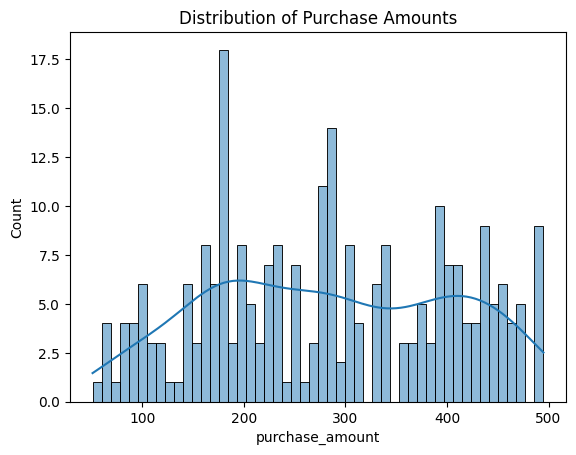

In [53]:
sns.histplot(final_df['purchase_amount'], bins=50, kde=True)
plt.title("Distribution of Purchase Amounts")
plt.show()

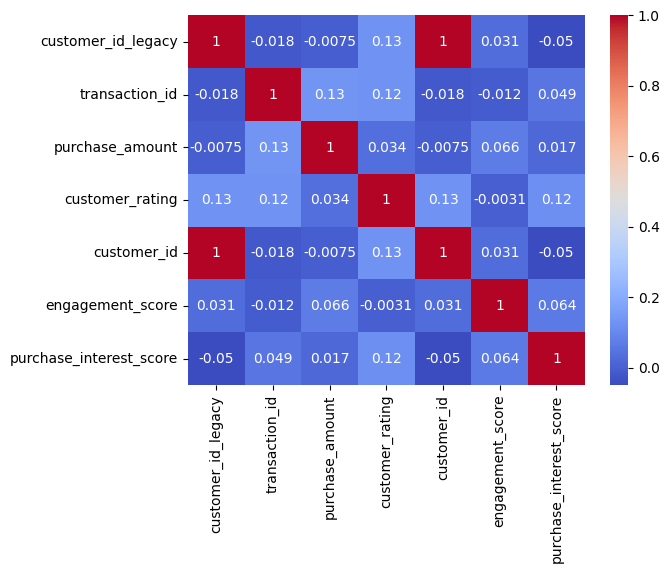

In [54]:
# Select only numeric columns for correlation
df_numeric = final_df.select_dtypes(include=[np.number])

# Calculate correlation matrix
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [60]:
from sklearn.model_selection import train_test_split

# Split the feature set X and target variable y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (197, 18)
Shape of X_test: (50, 18)
Shape of y_train: (197,)
Shape of y_test: (50,)


In [61]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Train the model using the training data
model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


In [62]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.43      0.50      0.46         6
           2       0.15      0.29      0.20         7
           3       0.50      0.45      0.48        11
           4       0.65      0.69      0.67        16

    accuracy                           0.46        50
   macro avg       0.48      0.43      0.42        50
weighted avg       0.52      0.46      0.46        50

Confusion Matrix:
[[ 2  2  2  2  2]
 [ 0  3  3  0  0]
 [ 1  1  2  1  2]
 [ 0  1  3  5  2]
 [ 0  0  3  2 11]]


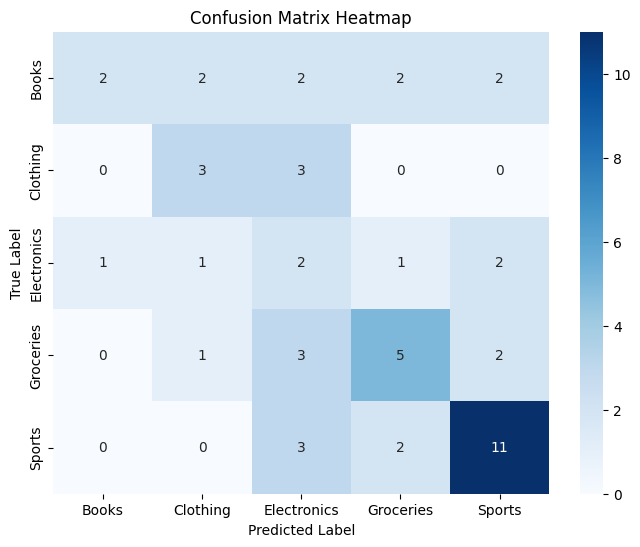

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names from the label encoder
class_names = label_encoder.classes_

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Display the plot
plt.show()